In [8]:
# Kolminkertainen eksponentiaalinen tasoitus
# Kolminkertaista eksponentiaalista tasoitusta kutsutaan myös Holt-Winterin malliksi. Eksponentiaalisen tasoituksen 
#mallit (yksinkertainen, kaksinkertainen ja kolminkertainen) ovat erityisen suosittuja liiketaloudessa kysynnän 
#ennustamisessa. Mallit ovat helppokäyttöisiä, nopeasti laskettavissa ja helposti päivitettävissä uusien havaintojen myötä.
# Holt-Winterin malli huomioi sekä trendin että kausivaihtelun.
# Eksponentiaalinen tasoitus löytyy statsmodels.tsa-kirjastosta.

import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [9]:
df=pd.read_excel('Saapuneet puhelut viikkotasolla.xlsx')
df

,Date,Saapuneet
0,2017-12-10,663
1,2017-12-17,941
2,2017-12-24,658
3,2017-12-31,1206
4,2018-01-07,991
...,...,...
160,2021-01-03,2233
161,2021-01-10,2505
162,2021-01-17,3626
163,2021-01-24,2996


In [10]:
df.index = pd.to_datetime(df['Date'],format="%Y-%m")
df=df.drop('Date',axis=1)
df

,Saapuneet
Date,
2017-12-10,663
2017-12-17,941
2017-12-24,658
2017-12-31,1206
2018-01-07,991
...,...
2021-01-03,2233
2021-01-10,2505
2021-01-17,3626


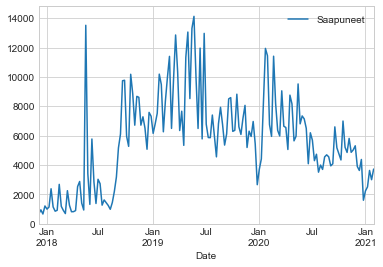

In [11]:
df.plot()

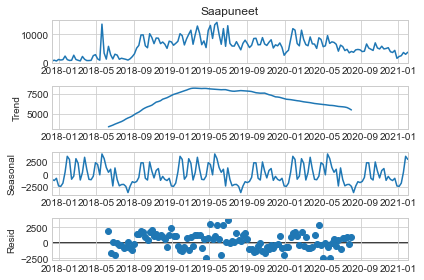

In [13]:
# Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
# Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
# Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu

decompose = seasonal_decompose(df['Saapuneet']).plot()

In [17]:
#Mallin sovitus
#Ennustemalli sovitetaan (fit()) dataan. Tuloksena saadaan olio (tässä olen antanut oliolle nimeksi malli), joka sisältää monenlaista tietoa mallista.
#Trendiin (trend) käytän summamallia (add), jossa trendi on aikasarjaan lisättävä termi. Tämä on suositeltavin vaihtoehto.
#Kausivaihteluun (seasonal) käytän summamallia (add) tai tulomallia (mul). Tulomallissa kausivaihtelu ilmenee kertoimina. Tässä olen kokeillut myös summamallia, mutta tulomalli osoittautui paremmaksi.
#seasonal_periods-parametrille käytän arvoa 20, koska kausivaihtelu esiintyy 20 viikon jaksoissa.
#freq-parametrille käytän arvoa 'W', koska kyseessä on viikkodata. Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
malli = ExponentialSmoothing(df['Saapuneet'], trend = 'add', seasonal = 'mul', 
                             seasonal_periods = 20, freq='W').fit()

In [18]:
# malli-olion avulla saan mallin mukaan simuloidut ennusteet (fittedvalues) jo toteutuneille ajankohdille
df['Ennuste'] = malli.fittedvalues
df

,Saapuneet,Ennuste
Date,,
2017-12-10,663,743.254035
2017-12-17,941,907.825906
2017-12-24,658,770.040630
2017-12-31,1206,844.134458
2018-01-07,991,927.514327
...,...,...
2021-01-03,2233,3223.712295
2021-01-10,2505,3619.731859
2021-01-17,3626,2689.342721


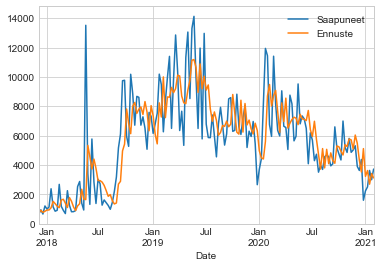

In [19]:
# Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kaavioon
df.plot()

In [20]:
# Ennustevirheet (residuaalit) löytyvät malli-oliosta
df['Ennustevirhe'] = malli.resid
df

,Saapuneet,Ennuste,Ennustevirhe
Date,,,
2017-12-10,663,743.254035,-80.254035
2017-12-17,941,907.825906,33.174094
2017-12-24,658,770.040630,-112.040630
2017-12-31,1206,844.134458,361.865542
2018-01-07,991,927.514327,63.485673
...,...,...,...
2021-01-03,2233,3223.712295,-990.712295
2021-01-10,2505,3619.731859,-1114.731859
2021-01-17,3626,2689.342721,936.657279


Text(0, 0.5, 'Ennustevirhe')

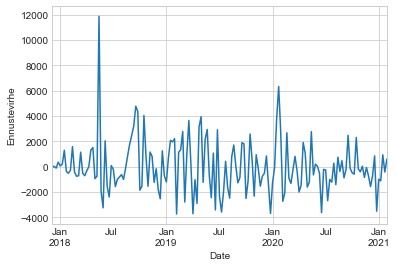

In [21]:
#Mallin tarkastelu
#Mallin hyvyyden tarkasteluun on monia tapoja. Tässä käytän
#ennustevirheiden aikasarjaa viivakaaviona
#ennusteiden ja toteutuneiden arvojen hajontakaaviota
#malliin liittyvää statistiikkaa, jonka saan summary()-toiminnolla.
#Huomaa erityisesti SSE (sum of squared errors). Mallia laskeva algoritmi yrittää saada SSE:n mahdollisimman pieneksi.
# Ennustevirheet aikasarjana
# On hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Text(0, 0.5, 'Toteutunut kysyntä')

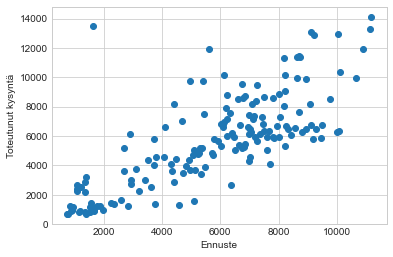

In [22]:
# Ennusteiden ja toteutuneiden kysyntöjen hajontakaavio
# Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa
# vasemmasta alakulmasta oikeaan yläkulmaan
plt.scatter(x = df['Ennuste'], y = df['Saapuneet'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut kysyntä')

In [23]:
malli.summary()

Dep. Variable:,endog,No. Observations:,165
Model:,ExponentialSmoothing,SSE,697007300.160
Optimized:,True,AIC,2565.300
Trend:,Additive,BIC,2639.842
Seasonal:,Multiplicative,AICC,2575.473
Seasonal Periods:,20,Date:,"Thu, 04 Feb 2021"
Box-Cox:,False,Time:,11:02:57
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3350505,alpha,True
smoothing_slope,3.0132e-14,beta,True


In [24]:
#Ennusteiden laskeminen
#Ennustettavien ajankohtien aikaleimojen määrittämiseksi:
#Ensimmäisen ennustettavan ajankohdan aikaleiman täytyy olla aikasarjan viimeisintä aikaleimaa seuraava aikaleima.
#Ennustettavien ajankohtien lukumäärän voin määrittää periods-parametrilla.
#Ennustettavien ajankohtien frekvenssin on oltava sama kuin mallia sovitettaessa käytetty freq-parametrin arvo.
#Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#Tarkistan viimeisen aikaleiman
df.tail()

,Saapuneet,Ennuste,Ennustevirhe
Date,,,
2021-01-03,2233,3223.712295,-990.712295
2021-01-10,2505,3619.731859,-1114.731859
2021-01-17,3626,2689.342721,936.657279
2021-01-24,2996,3417.989378,-421.989378
2021-01-31,3719,3116.732054,602.267946


In [34]:
# Ennustettavien ajankohtien aikaleimat (alkupäivänä aikasarjan viimeistä aikaleimaa seuraava aikaleima)
index = pd.date_range('2021-02-07', periods = 6, freq = 'W')

# Ennusteet 6 viikolle
ennusteet = malli.forecast(6)

# Ennusteet dataframeen
df_ennuste = pd.DataFrame(data = ennusteet, index = index, 
                          columns = ['Ennuste'])
df_ennuste

,Ennuste
2021-02-07,3234.569883
2021-02-14,3467.331356
2021-02-21,3461.766409
2021-02-28,3368.068605
2021-03-07,3332.655468
2021-03-14,3291.647578


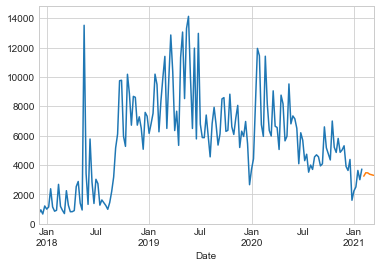

In [35]:
# Viivakaavio havainnoista
df['Saapuneet'].plot()

# Ennusteet kaavioon
df_ennuste['Ennuste'].plot()

In [36]:
# Dataframe, jossa alkuperäinen aikasarja ja lasketut ennusteet
df1 = pd.concat([df, df_ennuste])
df1

,Saapuneet,Ennuste,Ennustevirhe
2017-12-10,663.0,743.254035,-80.254035
2017-12-17,941.0,907.825906,33.174094
2017-12-24,658.0,770.040630,-112.040630
2017-12-31,1206.0,844.134458,361.865542
2018-01-07,991.0,927.514327,63.485673
...,...,...,...
2021-02-14,NaN,3467.331356,NaN
2021-02-21,NaN,3461.766409,NaN
2021-02-28,NaN,3368.068605,NaN
2021-03-07,NaN,3332.655468,NaN
